In [2]:
%matplotlib inline

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate 
import sys
import torch as pt

sys.path.insert(0, '..')

from problems import DoubleWell
from solver import Solver
from utilities import do_importance_sampling_me, plot_loss_logs, plot_solution, plot_control_for_DoubleWell1d, save_exp_logs, load_exp_logs

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

In [6]:
dw = DoubleWell(eta=3, kappa=5)
dw.compute_reference_solution()

In [ ]:
seed = 42

L = 1000
lr = 0.05
delta_t = 0.005
K = 10000
IS_K = 200000
IS_variance_iter = 5
print_every = 50

models = [Solver(name='moment', problem=dw, loss_method='moment', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True,
                 IS_variance_iter=IS_variance_iter, learn_Y_0=True),
          Solver(name='log-variance', problem=dw, loss_method='log-variance', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, IS_variance_iter=IS_variance_iter),
          Solver(name='relative entropy', problem=dw, loss_method='relative_entropy', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, IS_variance_iter=IS_variance_iter),
          Solver(name='cross-entropy', problem=dw, loss_method='cross_entropy', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, IS_variance_iter=IS_variance_iter)]

for model in models:
    model.train()

In [28]:
do_importance_sampling_me(dw, models[0], 10000000, control='true', simulate_naive=True, verbose=True, delta_t=0.01,
                          on_cpu=False, cross_statistics=pt.tensor([[0]]).to(models[0].device));

naive mean: 1.9994e-04, naive variance: 1.5797e-04, naive RE 6.2862e+01, crossed: 2021/10000000
IS mean: 1.9251e-04, IS variance: 1.3938e-07, IS RE 1.9394e+00, crossed: 8727639/10000000


## K = 50

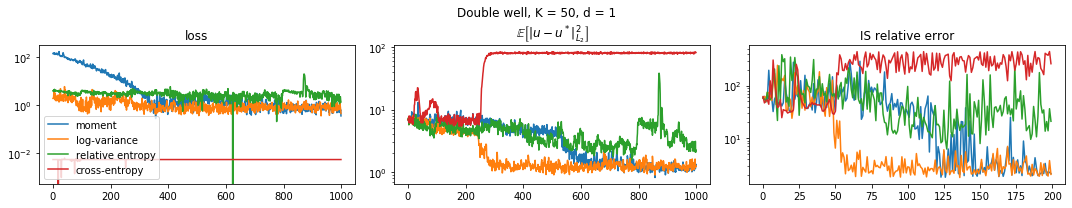

In [13]:
#save_exp_logs(models, 'paper/double_well_d1_K50')
fig = plot_loss_logs('Double well, K = %d' % models[0].K, models) # seed = 42424242

## K = 300

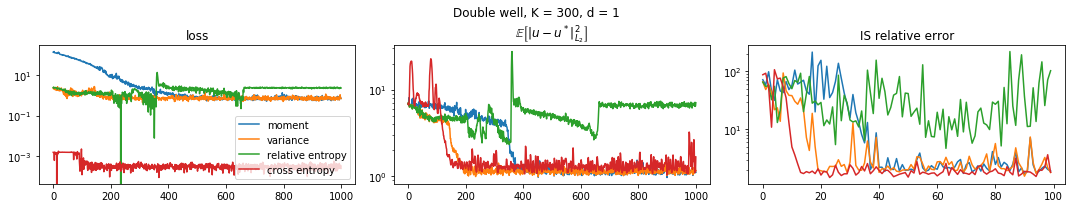

In [16]:
fig = plot_loss_logs('Double well, K = %d' % models[0].K, models) # seed = 42

## K = 1000

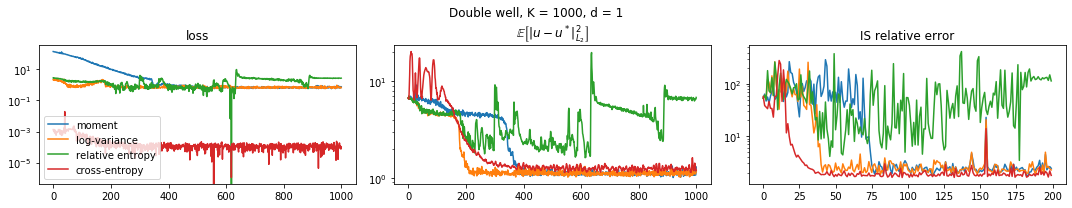

In [6]:
#save_exp_logs(models, 'paper/double_well_d1_K1000')
fig = plot_loss_logs('Double well, K = %d' % models[0].K, models) # seed = 42


2d control u has been stored to file: -2d.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



1d control u has been stored to file: -1d.eps


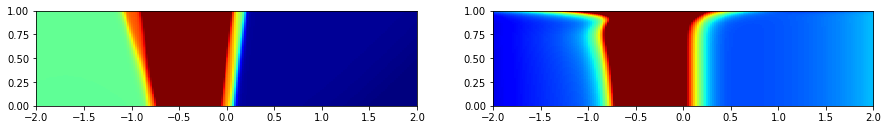

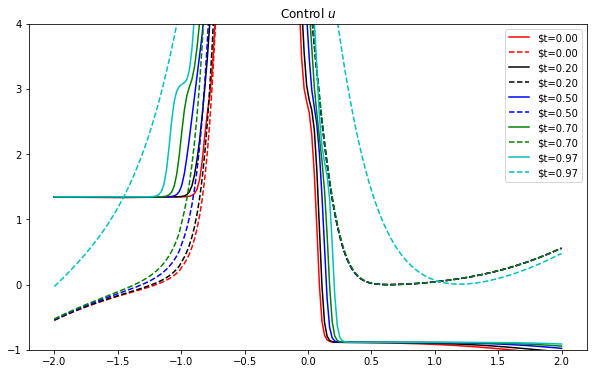

In [12]:
plot_control_for_DoubleWell1d(models[1], '', True);

## Plots for the paper

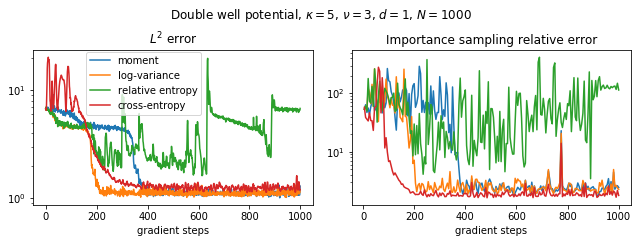

In [29]:
exp_logs = load_exp_logs('paper/double_well_d1_K1000_2020-04-25.json')

# double_well_d1_K50_2020-04-25.json - legend(bbox_to_anchor=(.32, .47), loc='lower left')
# double_well_d1_K1000_2020-04-25.json - legend(bbox_to_anchor=(.17, .55), loc='lower left')

fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))
fig.suptitle(r'Double well potential, $\kappa = 5$, $\nu = 3$, $d = 1$, $N = 1000$')

for model_name in exp_logs:
    ax[0].plot(exp_logs[model_name]['u_L2_loss'], label=model_name)
    ax[1].plot(np.arange(5, 1001, 5), exp_logs[model_name]['IS_rel_log'])
    ax[1].set_yscale('log')
    ax[1].set_title('Importance sampling relative error')
ax[0].set_yscale('log')
ax[0].set_title('$L^2$ error')
ax[0].legend(bbox_to_anchor=(.17, .55), loc='lower left')
ax[0].set_xlabel('gradient steps')
ax[1].set_xlabel('gradient steps')

fig.tight_layout(rect=[0, 0.03, 1, 0.93])
#fig.savefig('img/double_well_3_5_d_1_K_1000.pdf')

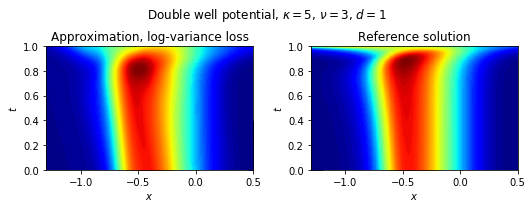

In [37]:
model = models[1]

fig, ax = plt.subplots(1, 2, figsize=(7.5, 3))

plt.suptitle(r'Double well potential, $\kappa = 5$, $\nu = 3$, $d = 1$')
x_l = -1.3
x_r = 0.5

x_1d = np.linspace(x_l, x_r, 200)
y_1d = np.linspace(0, 1, 200)
x_2d, y_2d = np.meshgrid(x_1d, y_1d)

X = pt.linspace(x_l, x_r, 200).unsqueeze(1).to(device)

Z = np.array([-model.Z_n(X, n * model.delta_t).cpu().detach().numpy().squeeze() for n in range(model.N)])
ax[0].contourf(x_2d, y_2d, Z, 100, cmap=cm.jet, vmin=Z.min(), vmax=Z.max());
ax[0].set_title('Approximation, log-variance loss')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$t$')

Z = np.array([model.u_true(X.cpu(), n * model.delta_t_np).squeeze() for n in range(model.N)])
ax[1].contourf(x_2d, y_2d, Z, 100, cmap=cm.jet, vmin=Z.min(), vmax=Z.max());
ax[1].set_title('Reference solution');
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
fig.tight_layout(rect=[0, 0.03, 1, 0.92])

for c in ax[0].collections:
    c.set_edgecolor("face")
for c in ax[1].collections:
    c.set_edgecolor("face")
#fig.savefig('img/double_well_1d_approx_plot.pdf')

In [3]:
dw_1 = DoubleWell(eta=1, kappa=1)
dw_1.compute_reference_solution(nx=10000)

dw_2 = DoubleWell(eta=3, kappa=5)
dw_2.compute_reference_solution(nx=20000)

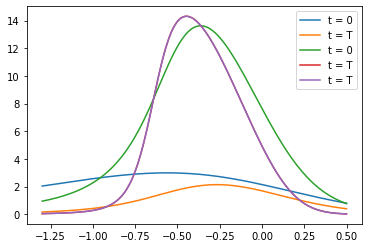

In [11]:
x_l = -1.3
x_r = 0.5

L = 200

x_1d = np.linspace(x_l, x_r, L)
y_1d = np.linspace(0, 1, L)
x_2d, y_2d = np.meshgrid(x_1d, y_1d)

X = pt.linspace(x_l, x_r, L).unsqueeze(1).to(device)

#Z = np.array([-model.Z_n(X, n * model.delta_t).cpu().detach().numpy().squeeze() for n in range(model.N)])

Z_1 = np.array([dw_1.u_true(X.cpu(), n * model.delta_t_np).squeeze() for n in range(model.N)])
Z_2 = np.array([dw_2.u_true(X.cpu(), n * model.delta_t_np).squeeze() for n in range(model.N)])

Z_1_interpolate = interpolate.interp1d(x_1d, Z_1[0, :], axis=0)
Z_2_interpolate = interpolate.interp1d(x_1d, Z_2[0, :], axis=0)

x_1d_ = np.linspace(x_l, x_r, 100)

plt.plot(x_1d, Z_1[189, :], label='t = 0');
plt.plot(x_1d, Z_1[0, :], label='t = T');
plt.plot(x_1d, Z_2[189, :], label='t = 0');
plt.plot(x_1d, Z_2[0, :], label='t = T');
plt.plot(x_1d_, Z_2_interpolate(x_1d_), label='t = T');
plt.legend();

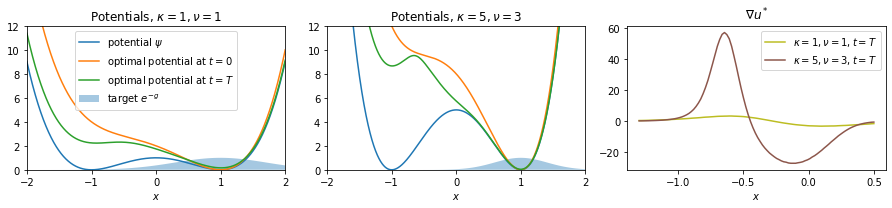

In [20]:
COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
          'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

def g(x, nu):
    return nu * (x - 1)**2

def psi(x, kappa):
    return kappa * (x**2 - 1)**2

x_l = -2
x_r = 2

x_val = np.linspace(x_l - 0.5, x_r + 0.5, 10000)
x_val_2 = np.linspace(x_l - 0.5, x_r + 0.5, 20000)

fig, ax = plt.subplots(1, 3, figsize=(12.5, 3))

ax[0].plot(x_val, psi(x_val, 1), label=r'potential $\psi$');
#ax[0].plot(x_val, np.exp(-g(x_val, 1)), label=r'target $e^{-g}$')
ax[0].fill_between(x_val, np.exp(-g(x_val, 1)), step='pre', alpha=0.4, label=r'target $e^{-g}$')
ax[0].plot(x_val, psi(x_val, 1) - np.log(dw_1.psi[200, :]), label=r'optimal potential at $t = 0$');
ax[0].plot(x_val, psi(x_val, 1) - np.log(dw_1.psi[0, :]), label=r'optimal potential at $t = T$');
ax[0].set_xlabel(r'$x$');
ax[0].set_xticks(np.linspace(-2, 2, 5))

ax[1].plot(x_val, psi(x_val, 5));
#ax[1].plot(x_val, np.exp(-g(x_val, 3)))
ax[1].fill_between(x_val, np.exp(-g(x_val, 3)), step='pre', alpha=0.4)
ax[1].plot(x_val_2, psi(x_val_2, 5) - np.log(dw_2.psi[200, :]));
ax[1].plot(x_val_2, psi(x_val_2, 5) - np.log(dw_2.psi[0, :]));
ax[1].set_xlabel(r'$x$');
ax[1].set_xticks(np.linspace(-2, 2, 5))

ax[2].plot(x_1d_, np.gradient(Z_1_interpolate(x_1d_), x_1d_), label=r'$\kappa = 1, \nu = 1, t = T$', color=COLORS[8]);
ax[2].plot(x_1d_, np.gradient(Z_2_interpolate(x_1d_), x_1d_), label=r'$\kappa = 5, \nu = 3, t = T$', color=COLORS[5]);
ax[2].set_xlabel(r'$x$');
ax[2].set_xticks(np.linspace(-1.0, 0.5, 4))

ax[0].set_xlim(x_l, x_r)
ax[1].set_xlim(x_l, x_r)
ax[0].set_ylim(0, 12)
ax[1].set_ylim(0, 12)
ax[0].set_title(r'Potentials, $\kappa = 1, \nu = 1$')
ax[1].set_title(r'Potentials, $\kappa = 5, \nu = 3$')
ax[2].set_title(r'$\nabla u^*$')
ax[0].legend(); #  loc='center left', bbox_to_anchor=(1, 0.5)
ax[2].legend();
fig.tight_layout()
#fig.savefig('img/double_well_1d_potential_target_4.pdf')

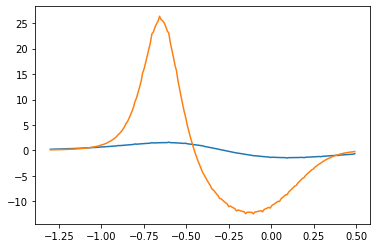

In [290]:
n = 10
plt.plot(X[:-1].cpu().numpy(), (Z_1[n, 1:] - Z_1[n, :-1]) / ((x_r - x_l) / 200))
plt.plot(X[:-1].cpu().numpy(), (Z_2[n, 1:] - Z_2[n, :-1]) / ((x_r - x_l) / 200));